## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 32.6 s, sys: 296 ms, total: 32.9 s
Wall time: 33.1 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 3
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_3'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sat Jan 11 14:56:32 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


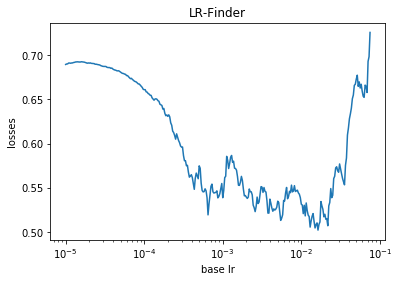

epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.5057 - spearmanr 0.25856
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.47082 - spearmanr 0.38723


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38723
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45165 - spearmanr 0.40824
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45274 - spearmanr 0.41564
best model: epoch 1 - 0.41564
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42639 - spearmanr 0.47641
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45032 - spearmanr 0.41951
best model: epoch 2 - 0.41951
TRAINING END: Best score achieved on epoch 2 - 0.41951
Starting inference for model: checkpoints/siamese_bert_3_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_1_best.pth



Fold 2 started at Sat Jan 11 15:27:41 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_2_best.pth



Fold 3 started at Sat Jan 11 15:28:21 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_3_best.pth



Fold 4 started at Sat Jan 11 15:29:02 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_4_best.pth



Fold 5 started at Sat Jan 11 15:29:42 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_5_best.pth



Fold 6 started at Sat Jan 11 15:30:23 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_6_best.pth



Fold 7 started at Sat Jan 11 15:31:03 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_7_best.pth



Fold 8 started at Sat Jan 11 15:31:43 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_8_best.pth



Fold 9 started at Sat Jan 11 15:32:24 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_9_best.pth



Fold 10 started at Sat Jan 11 15:33:04 2020
Starting inference for model: checkpoints/siamese_bert_3_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_3_fold_10_best.pth



OOF score: 0.41031797952499016


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [12]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

indices = [2, 5, 12, 13, 14, 15]
ds = [10, 5, 5, 20, 5, 5]
discrete_cols = np.array(TARGETS)[indices]
print(discrete_cols)

def ahmet_round(preds, ds=ds, indices=indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

['question_conversational' 'question_has_commonly_accepted_answer'
 'question_type_compare' 'question_type_consequence'
 'question_type_definition' 'question_type_entity']


In [22]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [3, 5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 3 0.3241959116907673
0 5 0.3539116872696059
0 10 0.3790786175193342
0 15 0.3809618339410658
0 20 0.3815562442295259
0 33 0.3830624472464342
0 None 0.3837959633234947
1 3 0.621997205813582
1 5 0.6491972009404586
1 10 0.6615700688224305
1 15 0.6645963188678411
1 20 0.6648088012312693
1 33 0.664999038033451
1 None 0.6657702627555317
2 3 0.4445620586308422
2 5 0.4867475948081961
3 3 0.25394253330755134
3 5 0.2884488018652375
3 10 0.29496708151717405
3 15 0.30087325436851753
3 20 0.3017497598894678
3 None 0.302804657326473
4 3 0.3228613125456082
4 5 0.3529720786167755
4 10 0.3584299928559169
4 20 0.3587882412571249
4 33 0.359607368938582
5 3 0.46760997660802717
6 3 0.22062342176522914
6 5 0.30259676865913954
6 10 0.34530869008181186
6 15 0.34915839098601853
6 20 0.3507058549415688
6 None 0.3519024942948026
7 3 0.46378864448925705
7 5 0.49126020044534824
7 10 0.5001016996729669
7 15 0.5008199270434653
7 33 0.5019012976258539
7 None 0.5020111217249873
8 3 0.5551977480536431
8 5 0.5722001570

In [23]:
opt_ds, opt_indices

([5, 33, 3, 33, 20, 10, 3, 20, 10, 5, 10, 33, 33, 20, 15, 15],
 [2, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 24, 26])

In [24]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.44525306814536875

In [16]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.4436432395133682

In [17]:
spearmanr_np(oofs, y)

0.41031797952499016

In [18]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.42529347523953587

In [19]:
spearmanr_np(ahmet_round(oofs), y)

0.432655762732102

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.822700,0.606757,0.336699,0.420720,0.533662,0.399967,0.682947,0.691007,0.708347,0.004008,0.707284,0.785448,0.024199,0.367336,0.005207,0.024593,0.098493,0.180147,0.787721,0.000775,0.824019,0.573177,0.206948,0.738640,0.701363,0.320697,0.035148,0.045657,0.770751,0.635181
1,46,0.462724,0.279110,0.010432,0.673089,0.642312,0.868605,0.439451,0.352340,0.046728,0.020105,0.474518,0.201602,0.004156,0.000762,0.001017,0.013282,0.884329,0.326320,0.073492,0.000166,0.223245,0.758264,0.474525,0.849371,0.918302,0.577462,0.940548,0.220579,0.044803,0.584879
2,70,0.703702,0.576812,0.033531,0.614484,0.819365,0.901766,0.514962,0.435678,0.285654,0.005296,0.288072,0.712988,0.024532,0.068587,0.001348,0.007341,0.174573,0.157993,0.741391,0.000702,0.663175,0.624018,0.282989,0.808603,0.807562,0.437865,0.066814,0.071098,0.811514,0.576552
3,132,0.552414,0.160868,0.006397,0.598914,0.658376,0.866602,0.404639,0.249985,0.197994,0.012324,0.560950,0.140891,0.002595,0.005380,0.000537,0.003947,0.793897,0.311723,0.633305,0.000127,0.424982,0.801611,0.586616,0.863023,0.915087,0.642099,0.819072,0.338838,0.659485,0.647182
4,200,0.770276,0.268402,0.044636,0.811169,0.732296,0.874867,0.672194,0.692984,0.167548,0.026423,0.347347,0.538915,0.007729,0.022899,0.008389,0.085386,0.173449,0.172238,0.576171,0.003145,0.336878,0.730333,0.550887,0.871366,0.866420,0.620386,0.227170,0.211454,0.721060,0.609149


In [27]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [28]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.825208,0.732010,0.285660,0.595585,0.526514,0.457385,0.577916,0.504816,0.313085,0.005759,0.739529,0.386783,0.530199,0.077227,0.012807,0.107073,0.190029,0.115815,0.561065,0.003749,0.754423,0.865115,0.576628,0.929815,0.898261,0.709310,0.107572,0.100761,0.881541,0.705921
1,0.907463,0.811366,0.043013,0.572271,0.920137,0.734813,0.508455,0.657140,0.265344,0.001155,0.279264,0.116335,0.919784,0.004952,0.515191,0.052519,0.034207,0.057396,0.368510,0.008245,0.823952,0.579780,0.317529,0.719288,0.761281,0.377926,0.020907,0.039386,0.576733,0.825547
2,0.626358,0.188460,0.005228,0.765594,0.759052,0.858059,0.509447,0.318602,0.180395,0.001392,0.399277,0.314772,0.005709,0.002911,0.000563,0.431418,0.649472,0.211830,0.115748,0.000045,0.492699,0.833217,0.570151,0.901700,0.889291,0.687920,0.552265,0.262810,0.483859,0.742231
3,0.769974,0.685762,0.261486,0.637310,0.705681,0.742294,0.610959,0.647968,0.257515,0.001228,0.371961,0.955387,0.014987,0.029046,0.011708,0.016541,0.030266,0.136437,0.527152,0.000399,0.868479,0.756458,0.787489,0.810025,0.857945,0.722660,0.052692,0.199028,0.880302,0.729794
4,0.729064,0.701139,0.003882,0.690619,0.840436,0.906344,0.460270,0.433301,0.180305,0.001655,0.235551,0.631419,0.002775,0.001730,0.002005,0.007261,0.758189,0.316464,0.198534,0.000155,0.778453,0.712640,0.427886,0.796751,0.866208,0.585283,0.908294,0.253409,0.042249,0.551642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.896938,0.382275,0.174954,0.855542,0.686108,0.680277,0.718314,0.760258,0.513592,0.001440,0.559924,0.894836,0.125911,0.077690,0.008024,0.140240,0.018619,0.044556,0.487116,0.001367,0.710893,0.845430,0.642838,0.933837,0.890986,0.667456,0.055694,0.077821,0.865178,0.733415
6075,0.890261,0.516149,0.080136,0.576387,0.496637,0.353973,0.786596,0.819998,0.035577,0.012112,0.724266,0.011374,0.007933,0.022216,0.000224,0.015318,0.804781,0.413051,0.210712,0.000153,0.762151,0.836844,0.586783,0.914491,0.939245,0.612630,0.763741,0.362578,0.367470,0.870759
6076,0.566372,0.222845,0.003783,0.660493,0.716996,0.899986,0.409190,0.266355,0.185233,0.002647,0.486928,0.366203,0.001622,0.000821,0.000351,0.002010,0.853027,0.386642,0.256628,0.000036,0.322818,0.362327,0.273115,0.569764,0.716263,0.296554,0.603217,0.205985,0.416264,0.175751
6077,0.796093,0.426636,0.583988,0.357485,0.281736,0.171130,0.591611,0.696263,0.801729,0.001812,0.889318,0.639978,0.161163,0.113892,0.007028,0.042456,0.083135,0.295378,0.678197,0.000493,0.865176,0.720334,0.484271,0.871150,0.861752,0.559136,0.034702,0.152802,0.853713,0.837048
